**Problem statement:**

<b> To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.
Importing Skin Cancer Data
Importing all the important libraries </b>


In [81]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import glob

In [82]:
# from google.colab import drive
# drive.mount('/content/drive')

In [83]:
root_path = 'MyDrive/Upgrad/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration'
#/content/drive/MyDrive/Upgrad/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration

In [84]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Upgrad/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Upgrad/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [85]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2256
118


In [86]:
batch_size = 32
img_height = 180
img_width = 180

In [87]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6756 files belonging to 9 classes.
Using 5405 files for training.


In [88]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6756 files belonging to 9 classes.
Using 1351 files for validation.


In [89]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [90]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

Visualize the data

code to visualize one instance of all the nine classes present in the dataset

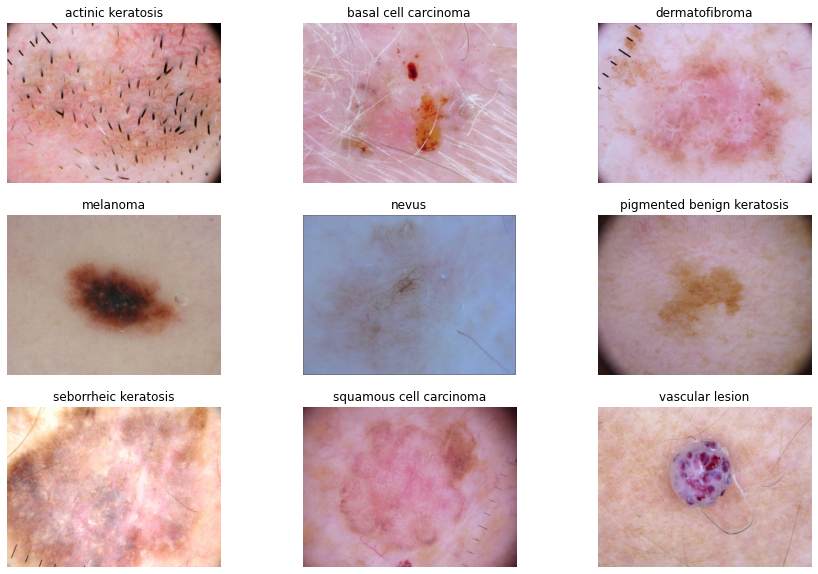

In [91]:
### Visualizing the training data

plt.figure(figsize=(15, 10))

for i, m_class in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), m_class)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(m_class)
    plt.axis("off")
plt.show()

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.


In [92]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


Check the configuration of gpu and use gpu.

In [93]:
# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)


[]


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

# Using data augmentation

In [94]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)



Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.


In [95]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

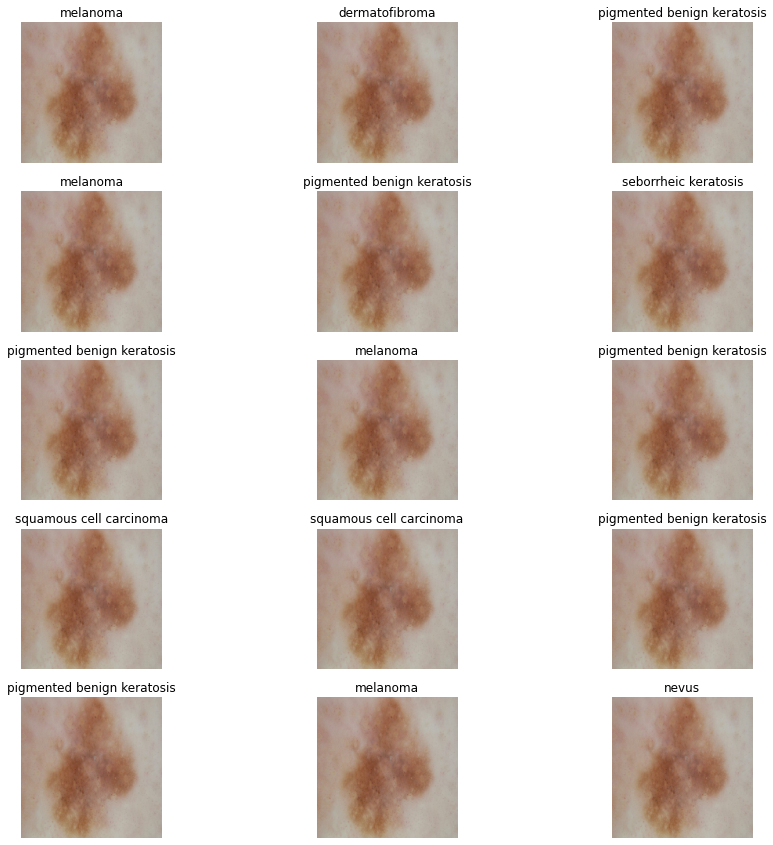

In [96]:
plt.figure(figsize=(15, 15))
for images, label in train_ds.take(1):
    for i in range(15):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")


Create the model

In [97]:


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

# layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). 
#The RGB channel values are in the [0, 255] range. This is not ideal for a
#neural network. Here, it is good to standardize values to be in the [0, 1]

num_classes = 9

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = data_augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

## Compiling the model

In [98]:
### We chose adam as optimiser and loss function for our model
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [99]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 activation_8 (Activation)   (None, 180, 180, 16)      0         
                                                      

## Training the Model

In [ ]:

epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)



Epoch 1/20
169/169 [==============================] - 205s 1s/step - loss: 1.7854 - accuracy: 0.3032 - val_loss: 1.5325 - val_accuracy: 0.4226
Epoch 2/20
169/169 [==============================] - 205s 1s/step - loss: 1.4844 - accuracy: 0.4416 - val_loss: 1.4861 - val_accuracy: 0.4219
Epoch 3/20
169/169 [==============================] - 197s 1s/step - loss: 1.3720 - accuracy: 0.4803 - val_loss: 1.3585 - val_accuracy: 0.4930
Epoch 4/20
169/169 [==============================] - 194s 1s/step - loss: 1.2749 - accuracy: 0.5167 - val_loss: 1.2328 - val_accuracy: 0.5463
Epoch 5/20
169/169 [==============================] - 194s 1s/step - loss: 1.2366 - accuracy: 0.5362 - val_loss: 1.1351 - val_accuracy: 0.5774
Epoch 6/20
169/169 [==============================] - 194s 1s/step - loss: 1.1706 - accuracy: 0.5558 - val_loss: 1.1429 - val_accuracy: 0.5625
Epoch 7/20
169/169 [==============================] - 195s 1s/step - loss: 1.1180 - accuracy: 0.5804 - val_loss: 1.1479 - val_accuracy: 0.5722

In [ ]:
# Visualizing training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Distribution of classes in the training dataset

### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

In [ ]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

In [ ]:
class_df.plot.bar()
plt.show()

## Rectify the class imbalance

Python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use Augmentor, the following general procedure is followed:

    Instantiate a Pipeline object pointing to a directory containing your initial image data set.
    Define a number of operations to perform on this data set using your Pipeline object.
    Execute these operations by calling the Pipeline’s sample() method.



In [ ]:
!pip install Augmentor

In [ ]:
import Augmentor

In [ ]:
path_to_training_dataset = '/content/drive/MyDrive/Upgrad/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/working/'+i+'/output/')
    #p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:


output_dir = pathlib.Path('/working/')
#output_dir = pathlib.Path('path_to_training_dataset')


In [ ]:
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

In [ ]:
#    data_path = os.path.join(str(data_dir_train), m_class)
#    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df = df2
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

# Train the model on the data created using Augmentor

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:

# Create your model (make sure to include normalization)

num_classes = 9

# Model - Rescaling -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

In [ ]:
#Compile your model (Choose optimizer and loss function appropriately)

model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# Train your model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


In [ ]:
# Visualize the model result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

We still have a overfitting model but we have much better accuracy than previous models.At end we have around 10% accuuracy difference between training and validation data. Class rebalance helped us in getting better accuracy.

We can reduce the overfitting by having a deeper model or add a data augmentation layer before it.


# Model with data augmentation and using Augmentor dataset

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
num_classes = 9

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense

model = data_augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

In [ ]:
model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
epochs = 50
# Train the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()



In [ ]:
test_dataset = image_dataset_from_directory(data_dir_test, image_size=(img_height, img_width), 
                                           batch_size=batch_size)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]] + "\n" + class_names[label_batch[i]])
    plt.axis("off")